### Load libraries and inspect data

In [1]:
# load modules
from pyspark.sql import SparkSession

from pyspark.mllib.stat import Statistics as stat
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, IntegerType
from pyspark.sql.functions import col, when, isnan, count, udf, struct, date_format, coalesce, lit, round
from math import sin, cos, sqrt, atan2, radians    
from pyspark.sql.functions import col, radians, asin, sin, sqrt, cos
import matplotlib.pyplot as plt
import os

In [2]:
#Spark session
spark = SparkSession.builder \
        .appName("model") \
        .config("spark.executor.memory", '18g') \
        .config('spark.executor.cores', '5') \
        .config('spark.executor.instances', '29') \
        .getOrCreate()

In [3]:
#Load data in
data = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/master_dataset.parquet')
print(type(data))

<class 'pyspark.sql.dataframe.DataFrame'>


In [4]:
#inspect
data.show(3)

+--------+----------+--------------+--------------------+--------------------+---------------------+----------+----+------------+--------------------+------------+--------------------+------------------+-------------------+-------+----------+---------+------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+---+------+-----+--------+------------+----+---------+---------+---------+--------------------+--------------------+--------+------------------+------------------+----------------------+----------------------+----------------------+-------------------+------------------+-------------------+------------------+--------------------+
| Borough|month_year|startStationId|    startStationName|startStationLatitude|startStationLongitude|      date|hour|tripduration|           starttime|endStationId|      endStationName|endStationLatitude|endStationLongitude| bikeid|  usertype|birthyear|gender|  temp|feels_like|temp_min|te

#### Data Pre-processing:
##### Create new columns crowDist and sales_rent_inventory_ratio

In [4]:
## Create Distnace columns
# radius of earth in miles
R = 3963.0

#Convert start/end latitude and longitude from degrees to Radians
data = data.withColumn("startRadLong", radians(data.startStationLongitude))
data = data.withColumn("endRadLong", radians(data.endStationLongitude))
data = data.withColumn("startRadLat", radians(data.startStationLatitude))
data = data.withColumn("endRadLat", radians(data.endStationLatitude))
data = data.withColumn("diffRadLong", (data.startRadLong-data.endRadLong))
data = data.withColumn("diffRadLat", (data.startRadLat-data.endRadLat))
data = data.withColumn("crowDist", asin(sqrt(sin(data.diffRadLat/2)**2 + cos(data.startRadLat) * cos(data.endRadLat) * sin(data.diffRadLong/2)**2)) * 2 * R)
data = data.drop("startRadLong","endRadLong","startRadLat","endRadLat","diffRadLong","diffRadLat")
data = data.withColumn("sales_rent_inventory_ratio", data.avg_sales_inventory/data.avg_rent_inventory)

---

#### Get wanted features and look at data

In [5]:
# retain these predictors
vars_to_keep = ["avg_median_sales_price",
                "sales_rent_inventory_ratio",
                "crowDist",
                "feels_like",
                "humidity",
                "wind_speed",
                "tripduration",
                "clouds_all",
                "peak_commute",
                "precip",
                "time_bin",
                "zipcodes"]

# subset the dataframe on these predictors
df = data[vars_to_keep]
df.show(2)

+----------------------+--------------------------+----------------+----------+--------+----------+------------+----------+------------+---------+--------+--------+
|avg_median_sales_price|sales_rent_inventory_ratio|        crowDist|feels_like|humidity|wind_speed|tripduration|clouds_all|peak_commute|   precip|time_bin|zipcodes|
+----------------------+--------------------------+----------------+----------+--------+----------+------------+----------+------------+---------+--------+--------+
|     854338.1216332259|       0.24110349330721517|             0.0|     57.38|      43|      3.93|        1062|         1|    non_peak|no_precip|   Night|   11217|
|     854338.1216332259|       0.24110349330721517|3.02116973218692|     57.38|      43|      3.93|        3810|         1|    non_peak|no_precip|   Night|   11205|
+----------------------+--------------------------+----------------+----------+--------+----------+------------+----------+------------+---------+--------+--------+
only showi

In [6]:
#Get count of trips by zip
cnt_trips = data.groupby("zipcodes").count()
cnt_trips.show(3)

+--------+------+
|zipcodes| count|
+--------+------+
|   11205|288665|
|   11106|332881|
|   11251| 85721|
+--------+------+
only showing top 3 rows



In [7]:
#Schema
df.printSchema()

root
 |-- avg_median_sales_price: double (nullable = true)
 |-- sales_rent_inventory_ratio: double (nullable = true)
 |-- crowDist: double (nullable = true)
 |-- feels_like: double (nullable = true)
 |-- humidity: long (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- tripduration: long (nullable = true)
 |-- clouds_all: long (nullable = true)
 |-- peak_commute: string (nullable = true)
 |-- precip: string (nullable = true)
 |-- time_bin: string (nullable = true)
 |-- zipcodes: string (nullable = true)



In [8]:
#Get a count of station
grouped_data = df.groupby("zipcodes")
agg_data = grouped_data.agg(F.avg("avg_median_sales_price").alias("avg_median_sales_price_by_zip"),
                 F.avg("sales_rent_inventory_ratio").alias("avg_sales_rent_ratio_by_zip"),
                 F.stddev("sales_rent_inventory_ratio").alias("std_of_avg_sales_rent_ratio_by_zip"),
                 #F.avg("avg_median_asking_rent").alias("avg_median_asking_rent_by_zip"),
                 #F.stddev("avg_median_asking_rent").alias("std_of_avg_median_asking_rent_by_zip"),
                 #F.avg("avg_price_cut_share").alias("avg_price_cut_share_by_zip"),
                 #F.stddev("avg_price_cut_share").alias("std_of_avg_price_cut_share_by_zip"),
                 #F.avg("avg_sales_volume").alias("avg_sales_volume_by_zip"),
                 #F.stddev("avg_sales_volume").alias("std_of_avg_sales_volume_by_zip"),
                 #F.avg("avg_sales_list_ratio").alias("avg_sales_list_ratio_by_zip"),
                 #F.stddev("avg_sales_list_ratio").alias("std_of_avg_sales_list_ratio_by_zip"),
                 F.avg("crowDist").alias("avg_crowDist"),
                 F.stddev("crowDist").alias("std_crowDist"), 
                 F.avg("feels_like").alias("avg_feels_like"),
                 F.stddev("feels_like").alias("std_feels_like"),
                 F.avg("humidity").alias("avg_humidity"),
                 F.stddev("humidity").alias("std_humidity"),
                 F.avg("wind_speed").alias("avg_wind_speed"),
                 F.stddev("wind_speed").alias("std_wind_speed"),
                 F.avg("tripduration").alias("avg_tripduration"),
                 F.stddev("tripduration").alias("std_tripduration"),
                 F.count(when(df.clouds_all == 1, lit(1))).alias("clouds_count"),
                 F.count(when(df.clouds_all == 0, lit(1))).alias("no_clouds_count"),
                 F.count(when(df.peak_commute == "peak", lit(1))).alias("peak_count"),
                 F.count(when(df.peak_commute == "non_peak", lit(1))).alias("non_peak_count"),
                 F.count(when(df.precip == "precip", lit(1))).alias("precip_count"),
                 F.count(when(df.precip == "no_precip", lit(1))).alias("non_precip_count"),
                 F.count(when(df.time_bin == "Morning", lit(1))).alias("morning_count"),
                 F.count(when(df.time_bin == "Afternoon", lit(1))).alias("afternoon_count"),
                 F.count(when(df.time_bin == "Evening", lit(1))).alias("evening_count"),
                 F.count(when(df.time_bin == "Night", lit(1))).alias("night_count"))

In [17]:
#Inspect
agg_data.show(2)

+--------+-----------------------------+---------------------------+----------------------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------+---------------+----------+--------------+------------+----------------+-------------+---------------+-------------+-----------+
|zipcodes|avg_median_sales_price_by_zip|avg_sales_rent_ratio_by_zip|std_of_avg_sales_rent_ratio_by_zip|      avg_crowDist|      std_crowDist|   avg_feels_like|    std_feels_like|      avg_humidity|     std_humidity|    avg_wind_speed|    std_wind_speed|  avg_tripduration|  std_tripduration|clouds_count|no_clouds_count|peak_count|non_peak_count|precip_count|non_precip_count|morning_count|afternoon_count|evening_count|night_count|
+--------+-----------------------------+---------------------------+----------------------------------+------------------+------------

In [9]:
#Get dataframe with counts
df = agg_data.join(cnt_trips, agg_data.zipcodes==cnt_trips.zipcodes, how="inner").drop(cnt_trips.zipcodes)
df = df.orderBy("zipcodes").withColumnRenamed("count", "trip_count_by_zip")

In [19]:
#Inspect
df.show(2)

+-----------------------------+---------------------------+----------------------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------+---------------+----------+--------------+------------+----------------+-------------+---------------+-------------+-----------+--------+-----------------+
|avg_median_sales_price_by_zip|avg_sales_rent_ratio_by_zip|std_of_avg_sales_rent_ratio_by_zip|      avg_crowDist|      std_crowDist|   avg_feels_like|    std_feels_like|      avg_humidity|      std_humidity|    avg_wind_speed|    std_wind_speed|  avg_tripduration|  std_tripduration|clouds_count|no_clouds_count|peak_count|non_peak_count|precip_count|non_precip_count|morning_count|afternoon_count|evening_count|night_count|zipcodes|trip_count_by_zip|
+-----------------------------+---------------------------+----------------------------------+--

In [10]:
#Schema
df.printSchema()

root
 |-- avg_median_sales_price_by_zip: double (nullable = true)
 |-- avg_sales_rent_ratio_by_zip: double (nullable = true)
 |-- std_of_avg_sales_rent_ratio_by_zip: double (nullable = true)
 |-- avg_crowDist: double (nullable = true)
 |-- std_crowDist: double (nullable = true)
 |-- avg_feels_like: double (nullable = true)
 |-- std_feels_like: double (nullable = true)
 |-- avg_humidity: double (nullable = true)
 |-- std_humidity: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)
 |-- std_wind_speed: double (nullable = true)
 |-- avg_tripduration: double (nullable = true)
 |-- std_tripduration: double (nullable = true)
 |-- clouds_count: long (nullable = false)
 |-- no_clouds_count: long (nullable = false)
 |-- peak_count: long (nullable = false)
 |-- non_peak_count: long (nullable = false)
 |-- precip_count: long (nullable = false)
 |-- non_precip_count: long (nullable = false)
 |-- morning_count: long (nullable = false)
 |-- afternoon_count: long (nullable = false

In [75]:
#Count of df - to be used to model
df.count()

115

#### Create pipeline

In [11]:
#Get numeric columns
num_feat = [i[0] for i in df.dtypes if i[1] != "string"]
num_feat

['avg_median_sales_price_by_zip',
 'avg_sales_rent_ratio_by_zip',
 'std_of_avg_sales_rent_ratio_by_zip',
 'avg_crowDist',
 'std_crowDist',
 'avg_feels_like',
 'std_feels_like',
 'avg_humidity',
 'std_humidity',
 'avg_wind_speed',
 'std_wind_speed',
 'avg_tripduration',
 'std_tripduration',
 'clouds_count',
 'no_clouds_count',
 'peak_count',
 'non_peak_count',
 'precip_count',
 'non_precip_count',
 'morning_count',
 'afternoon_count',
 'evening_count',
 'night_count',
 'trip_count_by_zip']

In [12]:
#PIPELINE indexer-standard scalar
#indexer = StringIndexer(inputCol="zipcodes", outputCol="zips_indexed")

#encoder = OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="zips_encoded")

assembler = VectorAssembler(inputCols=list((set(num_feat)-set(["avg_median_sales_price_by_zip"]))), outputCol="vectorized_features")

standardScaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="features")

#pipeline
pipeline = Pipeline(stages=[assembler] + [standardScaler])
model = pipeline.fit(df)
df_tr = model.transform(df)

In [24]:
#Inspect
df_tr.show(2)

+-----------------------------+---------------------------+----------------------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------+---------------+----------+--------------+------------+----------------+-------------+---------------+-------------+-----------+--------+-----------------+--------------------+--------------------+
|avg_median_sales_price_by_zip|avg_sales_rent_ratio_by_zip|std_of_avg_sales_rent_ratio_by_zip|      avg_crowDist|      std_crowDist|   avg_feels_like|    std_feels_like|      avg_humidity|      std_humidity|    avg_wind_speed|    std_wind_speed|  avg_tripduration|  std_tripduration|clouds_count|no_clouds_count|peak_count|non_peak_count|precip_count|non_precip_count|morning_count|afternoon_count|evening_count|night_count|zipcodes|trip_count_by_zip| vectorized_features|            features|
+-----------

#### Train/test split

In [13]:
#Train/test split
train, test = df_tr.randomSplit([0.7,0.3], seed=2021)

## Linear Regression Base Model - NOT tuned

In [14]:
#Fit log reg - Base model, un-tuned
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(labelCol='avg_median_sales_price_by_zip', featuresCol='features', maxIter=3)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)

In [15]:
#Inspect Coef and Intercept
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [6073.794661734495,3591.330687520557,-9442.851067524361,12504.567743138636,4161.821538564498,-9854.21032044762,3633.072248370087,-2269.5728221294016,3872.82740564915,-59566.8914631443,6792.09483970928,4049.194083626298,32586.148344187794,4137.222815420183,-3550.812328345512,10363.153871370065,4549.007611262373,2208.1979669202296,3803.6847591023393,-29754.56312586407,13570.910536101124,-20796.23501527694,2012.3903402215124]
Intercept: 1594964.886301717


In [16]:
#Train RMSE and R^2
trainingSummary = lrModel.summary
print("RMSE: " + str(trainingSummary.rootMeanSquaredError))
print("r2: " + str(trainingSummary.r2)) #0.4695 train

RMSE: 115283.46860195797
r2: 0.4695109860532617


In [29]:
#Predictions
predictions.select("prediction","avg_median_sales_price_by_zip").toPandas().head()

,prediction,avg_median_sales_price_by_zip
0,1.075212e+06,1.075142e+06
1,1.084568e+06,1.076856e+06
2,1.004292e+06,1.075421e+06
3,9.986049e+05,1.068129e+06
4,1.104778e+06,1.051391e+06


In [17]:
#Evaluate on TEST data - R2 and RMSE
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="avg_median_sales_price_by_zip",metricName="r2")
print("R Squared (R2) on test data: " + str(evaluator.evaluate(predictions))) #0.357 - test
test_result = lrModel.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data: " + str(test_result.rootMeanSquaredError))  #126482

R Squared (R2) on test data: 0.3575109314290945
Root Mean Squared Error (RMSE) on test data: 126482.78682174077


In [18]:
#Iteration and objective history
print("numIterations: " + str(trainingSummary.totalIterations))
print("objectiveHistory: " + str(trainingSummary.objectiveHistory))

numIterations: 4
objectiveHistory: [0.5000000000000036, 0.3434531501082567, 0.315237789256134, 0.26524450697336377]


#### Tune with Cross Validation

In [19]:
#Change response varaible to 'label'
df_tr_2 = df_tr.withColumnRenamed('avg_median_sales_price_by_zip', 'label')
#Train/test split
train, test = df_tr_2.randomSplit([0.7,0.3], seed=2021)

## Linear Regression Base Model (Tuned)

In [26]:
#Tune with CV - Base ModelLinear Regression tuned 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

#Linear regression model
lr = LinearRegression()

#Paramgrid
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0]) #regularization param
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) #Ridge=0, lasso=1.0
             .addGrid(lr.maxIter, [1, 5, 10]) #maxIter
             .build())



#10 fold cross validation
cv = CrossValidator(estimator=lr, estimatorParamMaps = paramGrid, evaluator=RegressionEvaluator(), numFolds=10)

In [27]:
#fit model
cvModel = cv.fit(train)

In [28]:
#Predictions
tune_preds = cvModel.transform(test)

In [29]:
# Evaluating metrics
eval_rmse = RegressionEvaluator(metricName="rmse")
eval_r2 = RegressionEvaluator(metricName="r2")
best_rmse = eval_rmse.evaluate(tune_preds)
best_r2 = eval_r2.evaluate(tune_preds)
print("R Squared (R2) on test data : " + str(best_r2)) #0.53685
print("RMSE on test data : " + str(best_rmse)) #107388

R Squared (R2) on test data : 0.5368528250602833
RMSE on test data : 107388.57119924371


In [30]:
#Best model paramaters
bm = cvModel.bestModel

print("Best model regularlization parameter: ", bm._java_obj.getRegParam())
print("Best model elastic net parameter: ", bm._java_obj.getElasticNetParam()) #lasso
print("Best model iteration: ", bm._java_obj.getMaxIter())

Best model regularlization parameter:  0.5
Best model elastic net parameter:  1.0
Best model iteration:  10


In [32]:
#Model Feature weights
best_coef = bm.coefficients

In [43]:
#Get list of importances and sort and take top 10
lis = []
for i in best_coef:
    lis.append(i)
output = list(zip(lis, num_feat[1:]))
output = sorted(output, key=lambda x: x[0], reverse=True)
#The weights were numpy-float64 so I needed to change its type to be able to create spark df
output = [(float(x[0]), x[1]) for x in output]

In [45]:
#get DF
schema = StructType([
    StructField("weight", DoubleType(), True),
    StructField("name", StringType(), True)
])
df_ticks = spark.createDataFrame(output, schema).toPandas()

In [56]:
#inspect
df_ticks

,weight,name
0,53118.463092,trip_count_by_zip
1,44647.188221,std_crowDist
2,41089.079957,clouds_count
3,25624.321800,avg_crowDist
4,18741.281632,evening_count
5,17340.132831,avg_tripduration
6,16800.841775,avg_sales_rent_ratio_by_zip
7,9960.431599,non_peak_count
8,7591.456175,precip_count
9,7157.125293,no_clouds_count


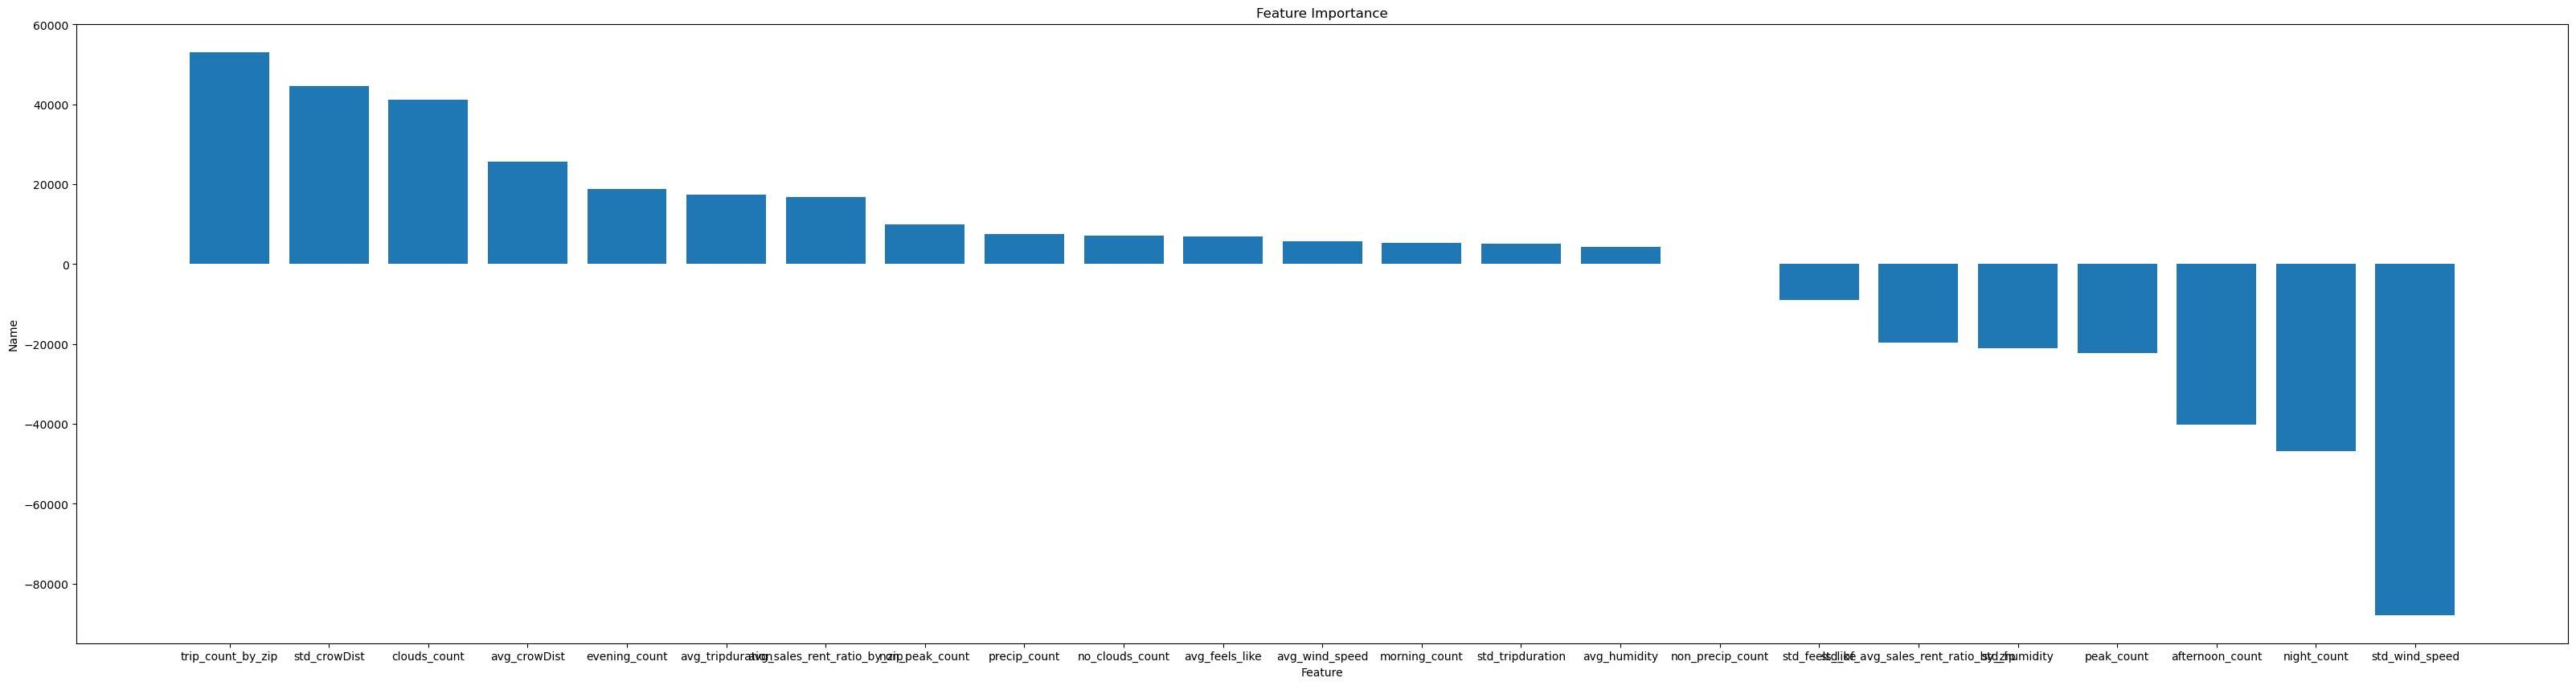

In [61]:
#plot of Feature Importance - need to work on graph look
plt.rcParams["figure.figsize"] = (40, 10)
plt.bar(df_ticks["name"], df_ticks["weight"], orientation = 'vertical')
plt.ylabel('Name')
plt.xlabel('Feature')
plt.title('Feature Importance')
plt.show()

Trip count and standarad deviation of crowDist look to be most imporant features. Non-peak trips add no value to the model.

---

---

# Random Forest Regression w/ All variables

In [5]:
#Load Libraries
from pyspark.ml.regression import RandomForestRegressor

In [6]:
#get column names
data.columns

['Borough',
 'month_year',
 'startStationId',
 'startStationName',
 'startStationLatitude',
 'startStationLongitude',
 'date',
 'hour',
 'tripduration',
 'starttime',
 'endStationId',
 'endStationName',
 'endStationLatitude',
 'endStationLongitude',
 'bikeid',
 'usertype',
 'birthyear',
 'gender',
 'temp',
 'feels_like',
 'temp_min',
 'temp_max',
 'pressure',
 'humidity',
 'wind_speed',
 'rain_1h',
 'rain_3h',
 'snow_1h',
 'snow_3h',
 'clouds_all',
 'weather_main',
 'dow',
 'day',
 'month',
 'time_bin',
 'peak_commute',
 'year',
 '3h_precip',
 '1h_precip',
 'precip',
 'start_lat_long',
 'end_lat_long',
 'zipcodes',
 'avg_days_on_market',
 'avg_discount_share',
 'avg_median_sales_price',
 'avg_median_asking_sale',
 'avg_median_asking_rent',
 'avg_price_cut_share',
 'avg_sales_volume',
 'avg_sales_inventory',
 'avg_rent_inventory',
 'avg_sales_list_ratio',
 'crowDist',
 'sales_rent_inventory_ratio']

In [6]:
# retain these predictors
vars_to_keep = ['tripduration',
                'startStationLatitude',
                'startStationLongitude',
                'endStationLatitude',
                'endStationLongitude',
                'usertype',
                'temp',
                'feels_like',
                'temp_min',
                'temp_max',
                'pressure',
                'humidity',
                'wind_speed',
                'rain_1h',
                'rain_3h',
                'snow_1h',
                'snow_3h',
                'clouds_all',
                'weather_main',
                'time_bin',
                'peak_commute',
                '3h_precip',
                '1h_precip',
                'precip',
                'zipcodes',
                'avg_median_sales_price',
                'crowDist',
                'sales_rent_inventory_ratio']

# subset the dataframe on these predictors
df_rf = data[vars_to_keep]
df_rf.show(2)

+------------+--------------------+---------------------+------------------+-------------------+----------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+--------+------------+---------+---------+---------+--------+----------------------+----------------+--------------------------+
|tripduration|startStationLatitude|startStationLongitude|endStationLatitude|endStationLongitude|  usertype|  temp|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_main|time_bin|peak_commute|3h_precip|1h_precip|   precip|zipcodes|avg_median_sales_price|        crowDist|sales_rent_inventory_ratio|
+------------+--------------------+---------------------+------------------+-------------------+----------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+--------+------------+---------+---------+---------+------

In [8]:
#print schema
df_rf.printSchema()

root
 |-- tripduration: long (nullable = true)
 |-- startStationLatitude: double (nullable = true)
 |-- startStationLongitude: double (nullable = true)
 |-- endStationLatitude: double (nullable = true)
 |-- endStationLongitude: double (nullable = true)
 |-- usertype: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- feels_like: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- pressure: long (nullable = true)
 |-- humidity: long (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- rain_3h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- snow_3h: double (nullable = true)
 |-- clouds_all: long (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- time_bin: string (nullable = true)
 |-- peak_commute: string (nullable = true)
 |-- 3h_precip: double (nullable = true)
 |-- 1h_precip: double (nullable = true)
 |-- precip: string (null

In [7]:
#Slice into grouped data
grouped_data = df_rf.groupby("zipcodes")
agg_data = grouped_data.agg(F.avg("avg_median_sales_price").alias("avg_median_sales_price_by_zip"),
                 F.avg("sales_rent_inventory_ratio").alias("avg_sales_rent_ratio_by_zip"),
                 F.stddev("sales_rent_inventory_ratio").alias("std_of_avg_sales_rent_ratio_by_zip"),
                 F.avg("crowDist").alias("avg_crowDist"),
                 F.stddev("crowDist").alias("std_crowDist"), 
                 F.avg("startStationLatitude").alias("avg_startStationLatitude"),
                 F.stddev("startStationLatitude").alias("std_startStationLatitude"), 
                 F.avg("startStationLongitude").alias("avg_startStationLongitude"),
                 F.stddev("startStationLongitude").alias("std_startStationLongitude"),
                 F.avg("endStationLatitude").alias("avg_endStationLatitude"),
                 F.stddev("endStationLatitude").alias("std_endStationLatitude"),
                 F.avg("endStationLongitude").alias("avg_endStationLongitude"),
                 F.stddev("endStationLongitude").alias("std_endStationLongitude"),
                 F.avg("temp").alias("avg_temp"),
                 F.stddev("temp").alias("std_temp"),
                 F.avg("temp_min").alias("avg_temp_min"),
                 F.stddev("temp_min").alias("std_temp_min"), 
                 F.avg("temp_max").alias("avg_temp_max"),
                 F.stddev("temp_max").alias("std_temp_max"), 
                 F.avg("feels_like").alias("avg_feels_like"),
                 F.stddev("feels_like").alias("std_feels_like"),
                 F.avg("pressure").alias("avg_pressure"),
                 F.stddev("pressure").alias("std_pressure"), 
                 F.avg("humidity").alias("avg_humidity"),
                 F.stddev("humidity").alias("std_humidity"),
                 F.avg("wind_speed").alias("avg_wind_speed"),
                 F.stddev("wind_speed").alias("std_wind_speed"),
                 F.avg("tripduration").alias("avg_tripduration"),
                 F.stddev("tripduration").alias("std_tripduration"),
                 F.count(when(df_rf.usertype == "Customer", lit(1))).alias("customer_count"),
                 F.count(when(df_rf.usertype == "Subscriber", lit(1))).alias("subscriber_count"),
                 F.count(when(df_rf.usertype == "member", lit(1))).alias("member_count"),
                 F.count(when(df_rf.clouds_all == 1, lit(1))).alias("clouds_count"),
                 F.count(when(df_rf.clouds_all == 0, lit(1))).alias("no_clouds_count"),
                 F.count(when(df_rf.peak_commute == "peak", lit(1))).alias("peak_count"),
                 F.count(when(df_rf.peak_commute == "non_peak", lit(1))).alias("non_peak_count"),
                 F.count(when(df_rf.precip == "precip", lit(1))).alias("precip_count"),
                 F.count(when(df_rf.precip == "no_precip", lit(1))).alias("non_precip_count"),
                 F.count(when(df_rf["1h_precip"] == 1.0, lit(1))).alias("1h_precip_count"),
                 F.count(when(df_rf["1h_precip"] == 0.0, lit(1))).alias("non_1h_precip_count"),
                 F.count(when(df_rf["3h_precip"] == 1.0, lit(1))).alias("3h_precip_count"),
                 F.count(when(df_rf["3h_precip"] == 0.0, lit(1))).alias("non_3h_precip_count"),
                 F.count(when(df_rf["rain_1h"] == 1.0, lit(1))).alias("rain_1h_count"),
                 F.count(when(df_rf["rain_1h"] == 0.0, lit(1))).alias("non_rain_1h_count"),
                 F.count(when(df_rf["rain_3h"] == 1.0, lit(1))).alias("rain_3h_count"),
                 F.count(when(df_rf["rain_3h"] == 0.0, lit(1))).alias("non_rain_3h_count"),
                 F.count(when(df_rf["snow_1h"] == 1.0, lit(1))).alias("snow_1h_count"),
                 F.count(when(df_rf["snow_1h"] == 0.0, lit(1))).alias("non_snow_1h_count"),
                 F.count(when(df_rf["snow_3h"] == 1.0, lit(1))).alias("snow_3h_count"),
                 F.count(when(df_rf["snow_3h"] == 0.0, lit(1))).alias("non_snow_3h_count"),
                 F.count(when(df_rf.weather_main == "Thunderstorm", lit(1))).alias("thunderstorm_count"),
                 F.count(when(df_rf.weather_main == "Drizzle", lit(1))).alias("drizzle_count"),
                 F.count(when(df_rf.weather_main == "Fog", lit(1))).alias("fog_count"),
                 F.count(when(df_rf.weather_main == "Clear", lit(1))).alias("clear_count"),
                 F.count(when(df_rf.weather_main == "Mist", lit(1))).alias("mist_count"),
                 F.count(when(df_rf.weather_main == "Clouds", lit(1))).alias("cloudy_day_count"),
                 F.count(when(df_rf.weather_main == "Rain", lit(1))).alias("rain_count"),
                 F.count(when(df_rf.weather_main == "Snow", lit(1))).alias("snow_count"),
                 F.count(when(df_rf.weather_main == "Haze", lit(1))).alias("haze_count"),
                 F.count(when(df_rf.time_bin == "Morning", lit(1))).alias("morning_count"),
                 F.count(when(df_rf.time_bin == "Afternoon", lit(1))).alias("afternoon_count"),
                 F.count(when(df_rf.time_bin == "Evening", lit(1))).alias("evening_count"),
                 F.count(when(df_rf.time_bin == "Night", lit(1))).alias("night_count"))

In [8]:
#Get count of trips by zip
cnt_trips = data.groupby("zipcodes").count()
cnt_trips.show(3)

+--------+------+
|zipcodes| count|
+--------+------+
|   11205|288665|
|   11106|332881|
|   11251| 85721|
+--------+------+
only showing top 3 rows



In [9]:
#Get dataframe with counts
df_rf = agg_data.join(cnt_trips, agg_data.zipcodes==cnt_trips.zipcodes, how="inner").drop(cnt_trips.zipcodes)
df_rf = df_rf.orderBy("zipcodes").withColumnRenamed("count", "trip_count_by_zip")

In [49]:
#inspect
df_rf.show(2)

+-----------------------------+---------------------------+----------------------------------+------------------+------------------+------------------------+------------------------+-------------------------+-------------------------+----------------------+----------------------+-----------------------+-----------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------+----------------+------------+------------+---------------+----------+--------------+------------+----------------+---------------+-------------------+---------------+-------------------+-------------+-----------------+-------------+-----------------+-------------+-----------------+-------------+-----------------+------------------+-------------+---------+

In [50]:
#get count
df_rf.count()

115

In [51]:
#Null values
df_rf.select([count(when(isnan(c), c)).alias(c) for c in df_rf.columns]).show() 

+-----------------------------+---------------------------+----------------------------------+------------+------------+------------------------+------------------------+-------------------------+-------------------------+----------------------+----------------------+-----------------------+-----------------------+--------+--------+------------+------------+------------+------------+--------------+--------------+------------+------------+------------+------------+--------------+--------------+----------------+----------------+--------------+----------------+------------+------------+---------------+----------+--------------+------------+----------------+---------------+-------------------+---------------+-------------------+-------------+-----------------+-------------+-----------------+-------------+-----------------+-------------+-----------------+------------------+-------------+---------+-----------+----------+----------------+----------+----------+----------+-------------+--------

In [10]:
#Drop nan
df_rf = df_rf.dropna()

---

## Create Pipeline

In [11]:
#Get numeric columns
num_feat = [i[0] for i in df_rf.dtypes if i[1] != "string"]
len(num_feat)

64

In [13]:
#inspect
num_feat

['avg_median_sales_price_by_zip',
 'avg_sales_rent_ratio_by_zip',
 'std_of_avg_sales_rent_ratio_by_zip',
 'avg_crowDist',
 'std_crowDist',
 'avg_startStationLatitude',
 'std_startStationLatitude',
 'avg_startStationLongitude',
 'std_startStationLongitude',
 'avg_endStationLatitude',
 'std_endStationLatitude',
 'avg_endStationLongitude',
 'std_endStationLongitude',
 'avg_temp',
 'std_temp',
 'avg_temp_min',
 'std_temp_min',
 'avg_temp_max',
 'std_temp_max',
 'avg_feels_like',
 'std_feels_like',
 'avg_pressure',
 'std_pressure',
 'avg_humidity',
 'std_humidity',
 'avg_wind_speed',
 'std_wind_speed',
 'avg_tripduration',
 'std_tripduration',
 'customer_count',
 'subscriber_count',
 'member_count',
 'clouds_count',
 'no_clouds_count',
 'peak_count',
 'non_peak_count',
 'precip_count',
 'non_precip_count',
 '1h_precip_count',
 'non_1h_precip_count',
 '3h_precip_count',
 'non_3h_precip_count',
 'rain_1h_count',
 'non_rain_1h_count',
 'rain_3h_count',
 'non_rain_3h_count',
 'snow_1h_count',
 

In [12]:
#PIPELINE
assembler = VectorAssembler(inputCols=list((set(num_feat)-set(["avg_median_sales_price_by_zip"]))), outputCol="vectorized_features")

standardScaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="features")

#Model
pipeline = Pipeline(stages=[assembler] + [standardScaler])
model = pipeline.fit(df_rf)
df_tr = model.transform(df_rf)

In [13]:
#rename median sales price column to label
df_tr = df_tr.withColumnRenamed("avg_median_sales_price_by_zip", "label")

#### Train/test split

In [14]:
#Train/test split
train, test = df_tr.randomSplit([0.7,0.3], seed=2021)

## Random Forest Regression - Tuned

In [15]:
#Random Forest Regressor
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor()

#### Tune with Paramgrid and Cross Validation

In [16]:
#Cross validation and Paramgrid
#Tune with CV
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()


#5 fold cross validation
cv = CrossValidator(estimator=rf, estimatorParamMaps = paramGrid, evaluator=RegressionEvaluator(), numFolds=5)

In [17]:
#Fit the data
cvModel = cv.fit(train)

In [18]:
#Get predictions
preds = cvModel.transform(test)

In [29]:
#See preds
preds.select("prediction", "label", "features").show(3)

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
|1052342.9852059237|1075141.7494834843|[20.2889272356576...|
|1055295.7251850844|1076856.4598026422|[18.7763681902345...|
| 1074307.725813578|1075420.6331545128|[18.9493598621292...|
+------------------+------------------+--------------------+
only showing top 3 rows



In [19]:
#Get predicted values on full data and plot - save r2 and rmse
#RMSE
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(preds)
#R^2
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(preds)

#get predictions on full dataset to plot
full_pred = cvModel.transform(df_tr)
final = full_pred.toPandas()

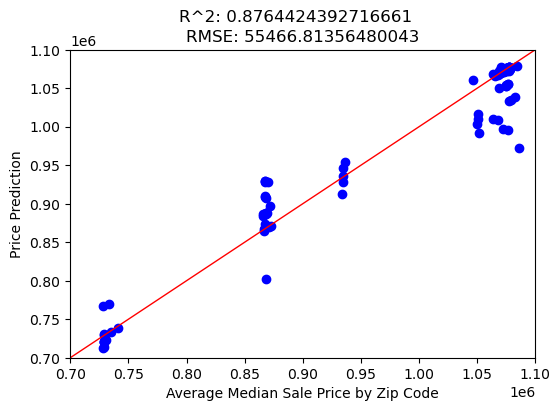

In [20]:
#plot
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(final.label, final.prediction, 'bo')
plt.axis([700000, 1100000, 700000, 1100000])
plt.xlabel('Average Median Sale Price by Zip Code')
plt.ylabel('Price Prediction')
plt.title("RMSE: " + str(rmse), y = 1)
plt.suptitle("R^2: " + str(r2))
plt.axline((0, 0), (1, 1), linewidth=1, color='r')
plt.show()

In [21]:
#show r2 and rmse for test
print("R Squared (R2) on test data: " + str(r2)) #0.8764
print("RMSE on test data: " + str(rmse)) #55466

R Squared (R2) on test data: 0.8764424392716661
RMSE on test data: 55466.81356480043


In [22]:
#Hyperparamter selection
bm = cvModel.bestModel
print('numTrees: ', bm.getNumTrees) 
print('maxDepth: ', bm.getOrDefault('maxDepth')) 

numTrees:  10
maxDepth:  25


In [23]:
#Feature Importance
importances = bm.featureImportances
x_values = list(range(len(importances)))

In [34]:
#Get list of importances and sort and take top 10
lis = []
for i in importances:
    lis.append(i)
output = list(zip(x_values, lis, num_feat[1:]))
output = sorted(output, key=lambda x: x[1], reverse=True)
top10 = output[0:10]

In [35]:
#Inspect output
output

[(16, 0.27521301144481897, 'avg_temp_max'),
 (29, 0.2528448510547657, 'subscriber_count'),
 (56, 0.16822144276409623, 'snow_count'),
 (3, 0.15142539302307984, 'std_crowDist'),
 (9, 0.04112542010412201, 'std_endStationLatitude'),
 (40, 0.017699807920390147, 'non_3h_precip_count'),
 (19, 0.015164424352427198, 'std_feels_like'),
 (10, 0.010981530064087633, 'avg_endStationLongitude'),
 (44, 0.007509444727810531, 'non_rain_3h_count'),
 (54, 0.007373348879898713, 'cloudy_day_count'),
 (2, 0.007202207109387626, 'avg_crowDist'),
 (55, 0.0059754471221185905, 'rain_count'),
 (47, 0.0052348101030170145, 'snow_3h_count'),
 (36, 0.004531210719347343, 'non_precip_count'),
 (28, 0.004330029069851486, 'customer_count'),
 (6, 0.004181224931921347, 'avg_startStationLongitude'),
 (7, 0.0036220226905565867, 'std_startStationLongitude'),
 (32, 0.0025105064672400357, 'no_clouds_count'),
 (60, 0.0020572177371495806, 'evening_count'),
 (45, 0.0017923842967025195, 'snow_1h_count'),
 (26, 0.001498573602524068, 

In [36]:
#The weights were numpy-float64 so I needed to change its type to be able to create spark df
top10 = [(float(x[1]), x[2]) for x in top10]

In [37]:
#get DF
schema = StructType([
    StructField("weight", DoubleType(), True),
    StructField("name", StringType(), True)
])
df_ticks = spark.createDataFrame(top10, schema).toPandas()

In [38]:
#Inspect
df_ticks

,weight,name
0,0.275213,avg_temp_max
1,0.252845,subscriber_count
2,0.168221,snow_count
3,0.151425,std_crowDist
4,0.041125,std_endStationLatitude
5,0.017700,non_3h_precip_count
6,0.015164,std_feels_like
7,0.010982,avg_endStationLongitude
8,0.007509,non_rain_3h_count
9,0.007373,cloudy_day_count


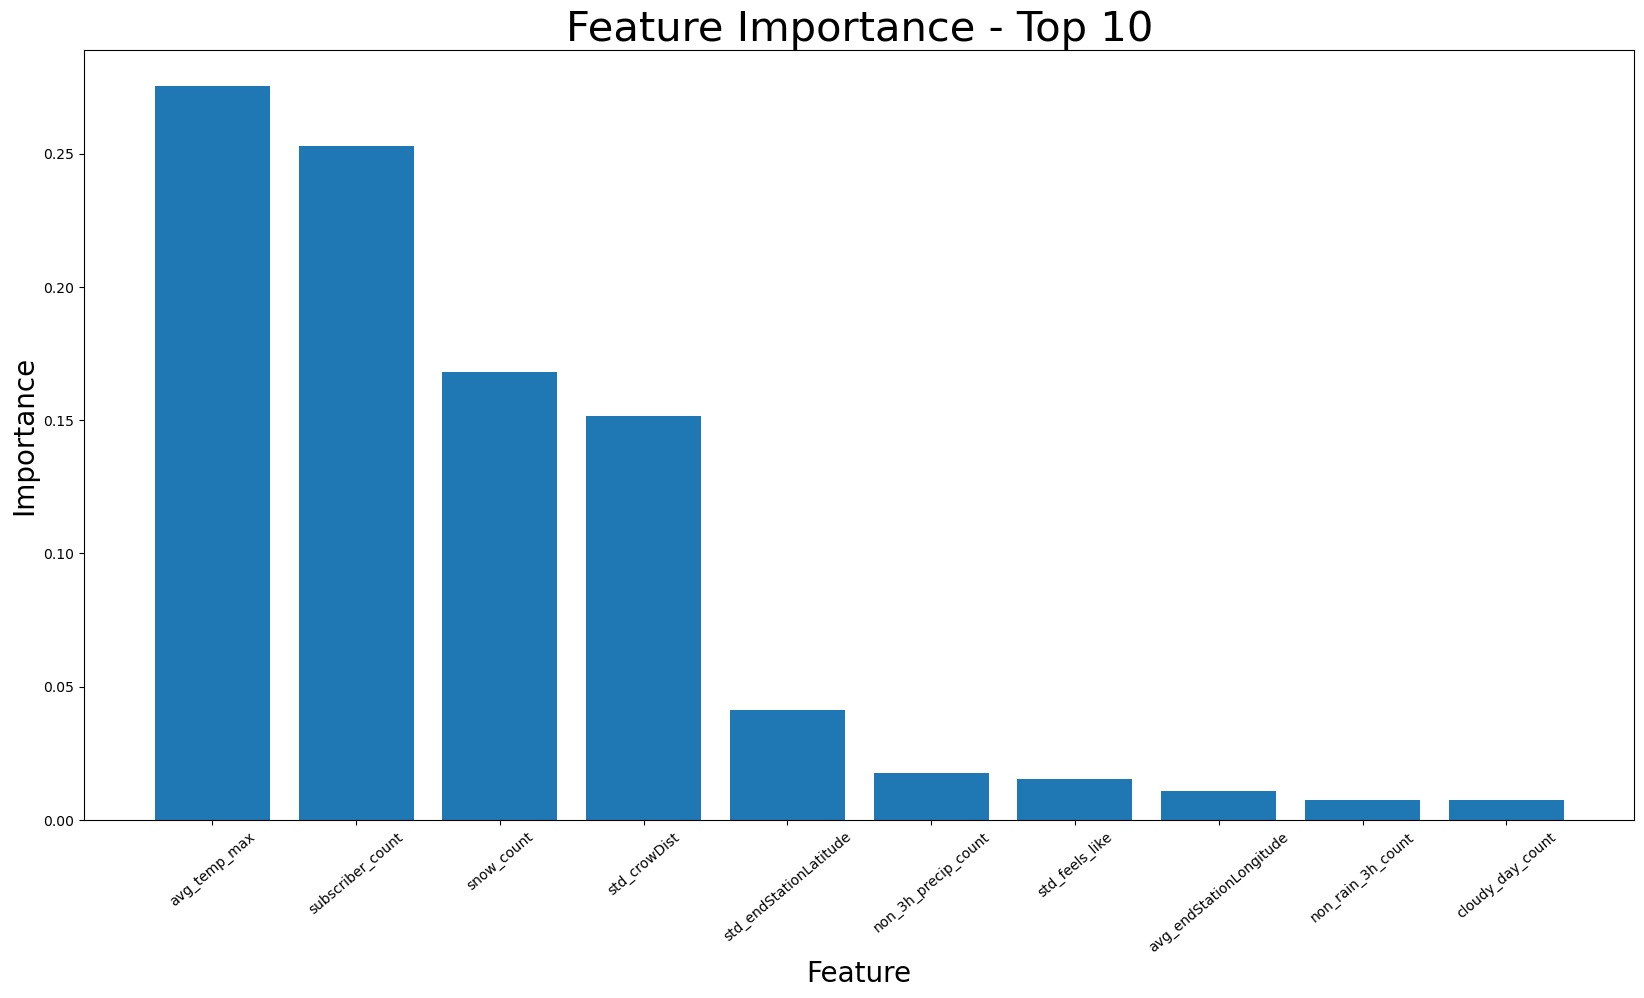

In [40]:
#plot of Feature Importance - need to work on graph look
plt.rcParams["figure.figsize"] = (20, 10)
plt.bar(x_values[0:10], df_ticks["weight"], orientation = 'vertical')
plt.xticks(x_values[0:10], df_ticks["name"], rotation=40)
plt.ylabel('Importance', size=20)
plt.xlabel('Feature', size=20)
plt.title('Feature Importance - Top 10', size=30)
plt.show()